<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 38

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [51]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from zipfile import ZipFile
import requests
import io
import torch
import torch.nn as nn

In [52]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [53]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [54]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [55]:
print(p.shape)

(2,)


In [56]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [57]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

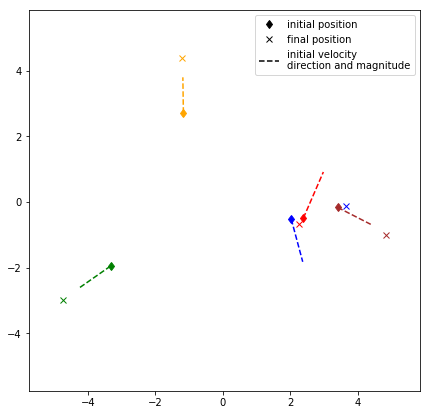

In [58]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [59]:
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.nn.functional import normalize
class MyDataset(Dataset):
    def __init__(self, veloc, pos, charges,time_id, norm):
        self.velocity = torch.FloatTensor(veloc)
        self.charges = torch.FloatTensor(charges)
        self.position = torch.FloatTensor(pos)
        self.time_id = time_id
        self.norm = norm

    def __getitem__(self, index):
        x_1 = self.velocity[index] #t=0 by default
        x_2 = self.charges[index] #t=0 by default
        x_2 = x_2.reshape(-1, 1, 5) # reshape from 128, 5, 1 -> 128, 1, 5
        x_2 = x_2.repeat(1, 2, 1) # 128, 2, 5
        x_3 = self.position[index, 0].view(1,2,5) # input pos of t=0
        reshaped_array = torch.cat([x_1, x_2, x_3], dim=1)
        y = self.position[index, self.time_id].view(1,2,5) # output pos of t=time_id

        if self.norm is not False:
            reshaped_array = normalize(reshaped_array)
            y = normalize(y)
        return reshaped_array, y

    def __len__(self):
        return len(self.charges)

In [103]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))])

train_dataset=MyDataset(velocities_train, positions_train, charges_train, time_id = 1, norm = False) # TURN NORM OFF FOR GRAPHING
val_dataset = MyDataset(velocities_valid, positions_valid, charges_valid, time_id = 1, norm = False)
test_dataset = MyDataset(velocities_test, positions_test, charges_test, time_id = 1, norm = False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [104]:
for x, y in test_loader:
    print("veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}")

    print(x.shape)
    print(len(test_loader))
    break
# normal nn  fix losses done
# fix dataloader done
# data augmentation (flip the order of ptxid)
# normalizing the data

veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}
torch.Size([128, 1, 6, 5])
16


# Model Implementation

In [117]:
# Simple NN network for value prediction
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_dim,30)
        self.layer2 = nn.Linear(30, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 30)
        self.layer5 = nn.Linear(30, 10)
        # self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = self.drop(x)
        x = F.relu(self.layer2(x))
        # x = self.drop(x)
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return x

# Model Training REGULAR NEURAL NET

In [118]:
# NN MODEL
from tqdm import tqdm
def train(model, train_loader, n_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    for _ in range(1, n_epochs + 1):
        output_val = [] #get output of last epoch in val
        model.train()

        for x, y in tqdm(train_loader):
            # try:
            y = y.view(y.shape[0], 10)
            x = x.view(x.shape[0], 30)
            # except RuntimeError:
            #     y = y.view(16, 10)
            #     x = x.view(16, 30)
            batch_loss = 0.0
            optimizer.zero_grad()
            outputs = model(x)
            # print(outputs.shape)
            # print(y.shape)
            loss = criterion(outputs, y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        avg_train_loss = batch_loss / len(train_loader) # batch size
        train_losses.append(avg_train_loss)

        with torch.no_grad():
            model.eval()
            for x, y in val_loader:
                # try:
                y = y.view(y.shape[0], 10)
                x = x.view(x.shape[0], 30)
                # except RuntimeError:
                #     y = y.view(80, 10)
                #     x = x.view(80, 30)
                val_batch_loss = 0.0
                outputs = model(x)
                output_val.append(outputs)
                loss = criterion(outputs, y)
                val_batch_loss += loss.item()

        avg_val_loss = val_batch_loss / len(val_loader) # batch size
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, output_val

In [119]:
learning_rate = 1e-3
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
model = SimpleModel(input_dim=30)
#print(model.layer1.weight) # checking if weights are getting updated
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainloss, valloss, output_val = train(model= model, train_loader= train_loader, n_epochs=10, optimizer= optimizer, criterion=loss_fn)
#print(model.layer1.weight) # checking if weights are getting updated

100%|██████████| 79/79 [00:00<00:00, 105.59it/s]


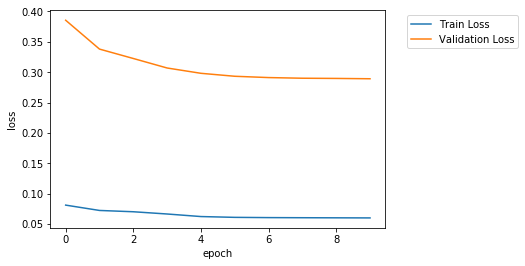

In [120]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(trainloss, label='Train Loss')
plt.plot(valloss, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Baseline

In [109]:
# GET FORMULA PREDICTIONS
def baseline_prediction():
    baseline_pred_x = []
    baseline_pred_y = []
    for sim in range(2000): # should be 2000
        for ptxd in range(5):
            #x_t = x_0 + v_0 * t for (x, y)
            x_pos, y_pos = (positions_test[sim, 0, 0, ptxd]) + (velocities_test[sim, 0, 0, ptxd]*0.5), positions_test[sim, 0, 1, ptxd] + (velocities_test[sim, 0, 1, ptxd]*0.5)
            baseline_pred_x.append(x_pos)
            baseline_pred_y.append(y_pos)
    return baseline_pred_x, baseline_pred_y
# charges_test
baseline_pred_x, baseline_pred_y = baseline_prediction()

## Prediction + label

In [110]:
# GET OUR PREDICTIONS AND LABELS
from tqdm import tqdm
def test(model, test_loader):
    output_test = [] #get output of last epoch in val
    labels = []
    with torch.no_grad():
        model.eval()
        for x, y in test_loader:
            y = y.view(y.shape[0], 10)
            x = x.view(x.shape[0], 30)
            outputs = model(x)
            output_test.append(outputs)
            labels.append(y)
    return output_test, labels

In [111]:
test_output, labels = test(model, test_loader)
# append predictions and labels to list
def split_output():
    test_x = []
    test_y = []
    act_x = []
    act_y = []
    for batch in test_output:
        arr = batch.numpy()
        for sim in range(arr.shape[0]):
            y = arr[sim][1::2] # take every even index
            x = arr[sim][::2] # take every even index
        
            test_x.extend(x)
            test_y.extend(y)
    
    for lab_batch in labels:
        arr_lab = lab_batch.numpy()
        for sim in range(arr_lab.shape[0]):
            y_lab = arr_lab[sim][1::2] # take every even index
            x_lab = arr_lab[sim][::2] # take every even index
        
            act_x.extend(x_lab)
            act_y.extend(y_lab)
    
    return test_x, test_y, act_x, act_y

x_pred, y_pred, x_act, y_act = split_output()

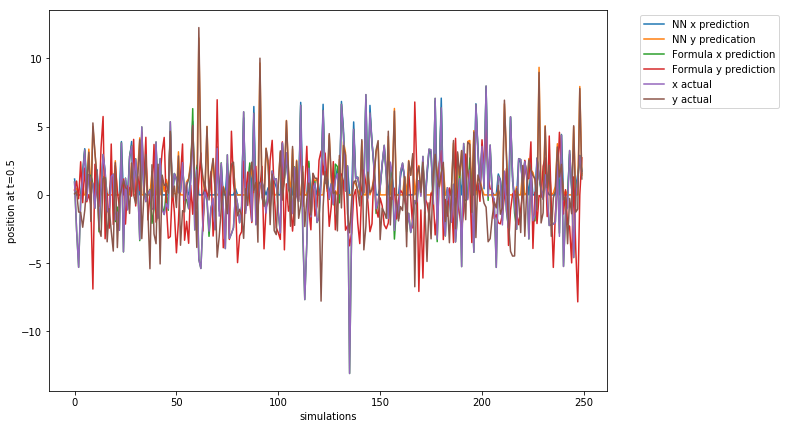

In [113]:
fig = plt.figure()
plt.xlabel('simulations')
plt.ylabel('position at t=0.5')
fig.set_size_inches(10, 7)
plt.plot(x_pred[::40], label='NN x prediction') 
plt.plot(y_pred[::40], label='NN y predication') #tends to predict 0 here
plt.plot(baseline_pred_x[::40], label='Formula x prediction')
plt.plot(baseline_pred_y[::40], label='Formula y prediction')
plt.plot(x_act[::40], label='x actual ')
plt.plot(y_act[::40], label='y actual')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# PROBLEM: DATA IS NORMALIZED BUT BASELINE PREDICTIONS ARENT

## RNN TEST

In [ ]:
# LSTmodel RNN
# NOT FINISHED
#####
#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
####
class LSTMModel(nn.Module):
    # input dim are the features which should be only 1 right t=0?
    # or is it 5 because 5 particles?
    def __init__(self, input_dim =5 , hidden_dim = 256, layer_dim = 2, output_dim = 2, dropout_prob = 0.2):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

# Evaluation

In [ ]:
# NN MODEL
from tqdm import tqdm
def train(model, train_loader, n_epochs, optimizer, criterion):
    train_losses = []
    val_losses = []
    for epoch in range(1, n_epochs + 1):
        running_loss = 0.0
        model.train()

        for veloc, charges, position, y in tqdm(train_loader):
            pt_loss = 0.0
            init_veloc_xy = veloc[:, 0, :, :]
            init_pos_xy = position[:, 0, :, :] 
            charge = charges[:, :, 0]
            print(init_pos_xy.shape)
            print(charge.shape)
            print(init_veloc_xy.shape)
            break
            x = torch.cat([init_pos_xy, charge, init_veloc_xy], dim=0) 
            y = y[:, -1, :, -1] # get [128, 2] batch x,y coordinate
            y = torch.squeeze(y) # flattens dimensions of 1
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            pt_loss += loss.item()
            loss.backward()
            optimizer.step()
            pt_loss = pt_loss/10
            running_loss += pt_loss
                    
        avg_train_loss = running_loss / (len(train_loader) * 128) # batch size
        train_losses.append(avg_train_loss)

    return train_losses

In [ ]:

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
RNN_network = LSTMModel()
optimizer = optim.Adam(RNN_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_loss = train(model= RNN_network, train_loader=train_loader, n_epochs=10, optimizer= optimizer, criterion=loss_fn)
